# Sell Naked Put Strategy 2.0

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime as dt
from datetime import timedelta
import yfinance as yf

Delta di tempo consigliato: 1/2 anni

Formato data: anno-mese-giorno

In [11]:
start = dt(2010,1,1)
end = dt.today()

In [12]:
spx = yf.download("^GSPC", start=start, end=end)
spx = np.round(spx['Close'])

spx_ret = np.log(spx/spx.shift(1)).dropna()

vix = yf.download("^VIX", start=start, end=end)

c:\Users\pc_hu\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\pc_hu\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


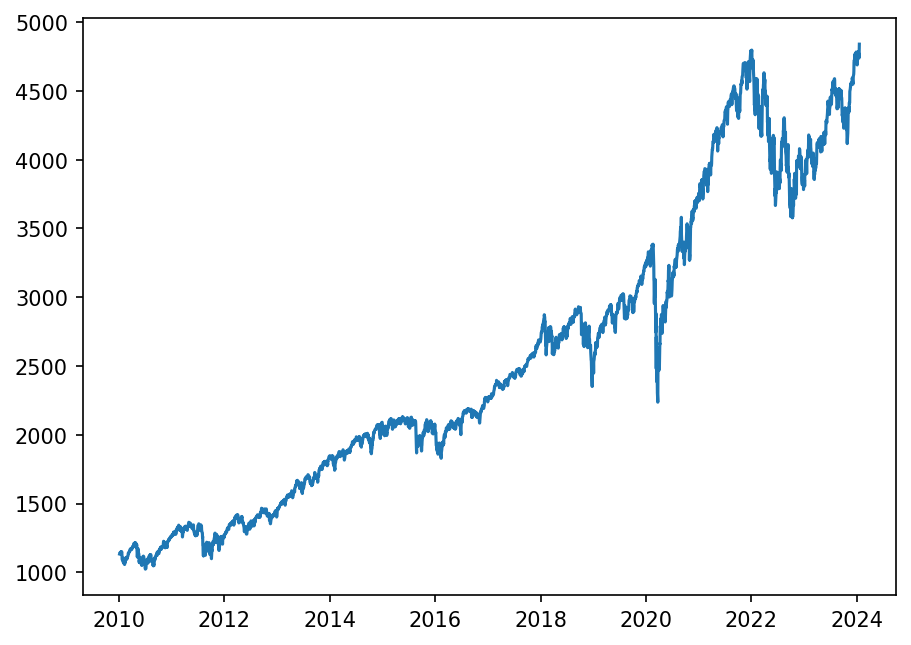

In [13]:
figure(figsize=(7, 5), dpi=150)
plt.plot(spx)

In [14]:
def deltaStrikeITM(spx):
    dist = []
    for t in range(len(spx)-21):
        if(spx[t+21]<=spx[t]):
            dist.append(abs( (spx[t+21]/spx[t])-1 ))
        else:
            dist.append(0)
    return dist

The deltaStrikeITM function calculates the difference between the price on day t and the price on day t+1 (which is one month later), but only if the price on day t+1 is less than or equal to the price on day t.

In [15]:
dif1 = deltaStrikeITM(spx)
#Aggiorno dif1 togliendo gli zeri
dif1_up = [value for value in dif1 if value != 0]

C:\Users\pc_hu\AppData\Local\Temp\ipykernel_10340\1351650072.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(spx[t+21]<=spx[t]):
C:\Users\pc_hu\AppData\Local\Temp\ipykernel_10340\1351650072.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist.append(abs( (spx[t+21]/spx[t])-1 ))


1) In the first bar plot, we can see on the Y-axis all the previously calculated deltas. The bar is set to 0 if the put option was out of the money (OTM) in the following month.

2) The second chart displays the time series of the VIX: Volatility Index from the Chicago Board Options Exchange, a popular measure of the stock market's expected volatility based on S&P 500 index options.

3) The third chart shows the histogram of the deltas, excluding zeros.

C:\Users\pc_hu\AppData\Local\Temp\ipykernel_10340\1613041939.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvline(x=pd.Series(dif1_up).describe()[3], linewidth=2, color='r', label='Min')  # min
C:\Users\pc_hu\AppData\Local\Temp\ipykernel_10340\1613041939.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvline(x=pd.Series(dif1_up).describe()[4], linewidth=2, color='b', label='1st Quartile (25%)')  # 1st quartile 25%
C:\Users\pc_hu\AppData\Local\Temp\ipykernel_10340\1613041939.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

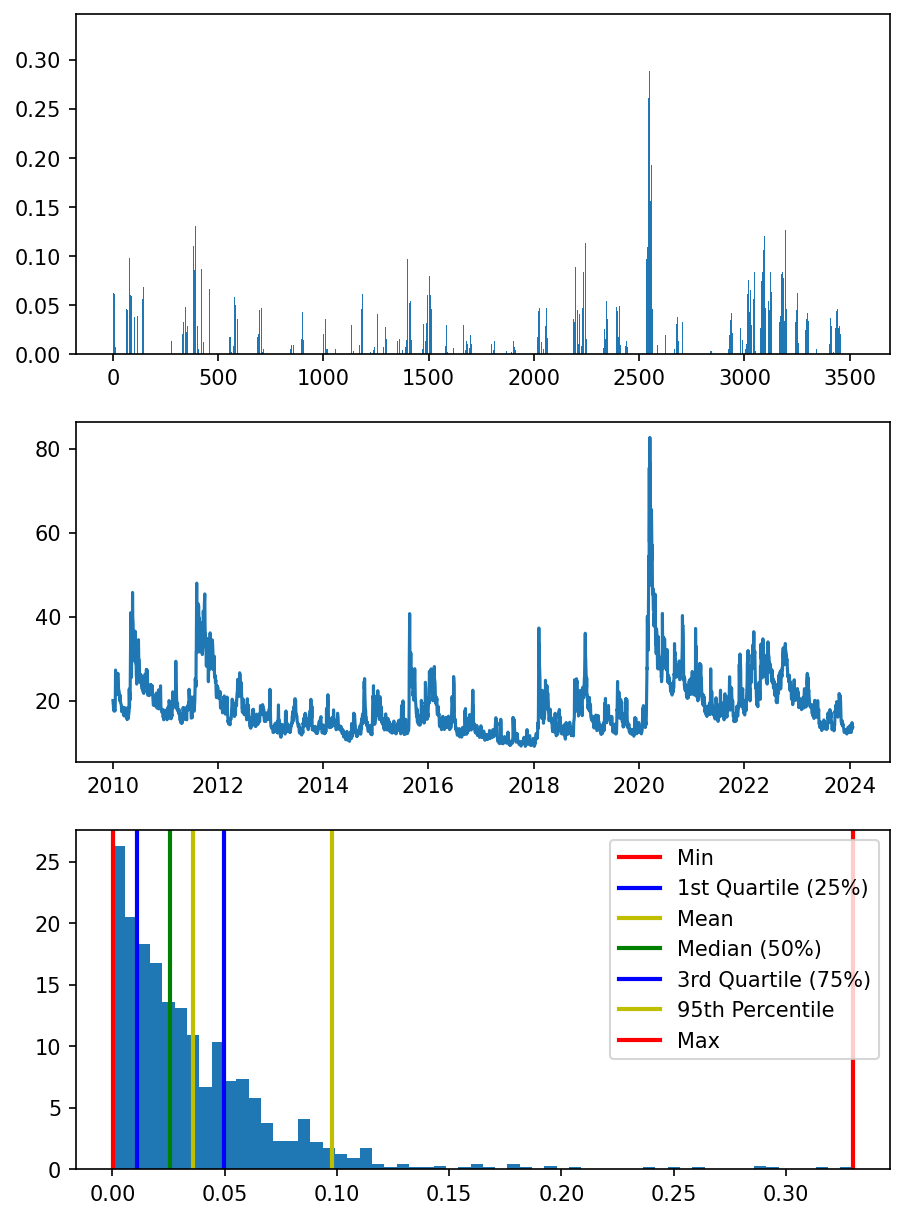

In [16]:

plt.figure(figsize=(7, 10), dpi=150)

plt.subplot(311)
plt.bar(np.arange(1,len(dif1)+1), dif1)

plt.subplot(312)
plt.plot(vix['Close'])

plt.subplot(313)
plt.hist(dif1_up, density=True, bins=60)
plt.axvline(x=pd.Series(dif1_up).describe()[3], linewidth=2, color='r', label='Min')  # min
plt.axvline(x=pd.Series(dif1_up).describe()[4], linewidth=2, color='b', label='1st Quartile (25%)')  # 1st quartile 25%
plt.axvline(x=pd.Series(dif1_up).describe()[1], linewidth=2, color='y', label='Mean')  # mean
plt.axvline(x=pd.Series(dif1_up).describe()[5], linewidth=2, color='g', label='Median (50%)')  # median value distribution 50%
plt.axvline(x=pd.Series(dif1_up).describe()[6], linewidth=2, color='b', label='3rd Quartile (75%)')  # 3rd quartile 75%
plt.axvline(x=np.percentile(dif1_up, 95), linewidth=2, color='y', label='95th Percentile')  # 95th percentile
plt.axvline(x=pd.Series(dif1_up).describe()[7], linewidth=2, color='r', label='Max')  # max

plt.legend(loc='upper right')
plt.show()

#Come possiamo osservare in prossimita delle barre verticali abbiamo segli spike nel VIX, tendenzialmente la volatilità aumenta
#con ritorni negativi dell'indice.

In [17]:
mean_dif1_up = np.round(np.mean(dif1_up), 4)
print(f'Mean of the deltas rounded up (excluding zeros): {mean_dif1_up}')

Mean of the deltas rounded up (excluding zeros): 0.036


In [18]:
pd.Series(dif1_up).describe()

count    1164.000000
mean        0.035980
std         0.037625
min         0.000213
25%         0.010840
50%         0.025782
75%         0.049587
max         0.329838
dtype: float64

In [31]:
#Scarico l'ultimo Close price dell'SP500
price_today = np.round(spx[-1])
print('Current SP500 quote:',price_today)

Current SP500 quote: 4840.0


C:\Users\pc_hu\AppData\Local\Temp\ipykernel_10340\1341502777.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_today = np.round(spx[-1])


By rounding down the current SP500 quote and subtracting the mean of the deltas (rounded up), we can identify an initial strike price at which to short put options. However, this strike price could be fairly risky.

In [32]:
print('Strike price:', np.round(price_today - price_today*mean_dif1_up, 2))

Strike price: 4665.76


For a less risky approach, we can subtract the value rounded up from the 95th percentile of the distribution.

In [33]:
perc95_dif1_up = np.round(np.percentile(dif1_up, 95), 4)
print('95 esimo percentile arrotondato per eccesso:', perc95_dif1_up)

95 esimo percentile arrotondato per eccesso: 0.0977


The 95th percentile of the distribution encompasses 95% of the put options that have gone into the money over the considered time frame. By subtracting this value from the current SP500 price, we position ourselves in the top 5% of the distribution, thereby ensuring a much less risky position.

In [34]:
print('Strike price:', np.round(price_today - price_today*perc95_dif1_up, 2))

Strike price: 4367.13
